# Geneformer Fine-Tuning for Classification of Dosage-Sensitive vs. -Insensitive Transcription Factors (TFs)

In this tutorial, we will finetune model with Geneformer for the gene classification task. We will subset the Genecorpus 30M dataset to use as the dataset to finetune Geneformer model. We then apply the resulting model on the pancreas dataset described in the [scIB Github](https://github.com/theislab/scib) to identify dosage sensitive and insensitive transcription factors. 

There are 5 main steps mentioned in this notebook:

* Prepare training dataset
* Prepare Configuation
* Prepare Geneformer model for classification
* Model Inference
* Evaluate the performance of the model

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import glob
import datetime
import pickle
import subprocess

os.environ["NCCL_DEBUG"] = "INFO"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = ""

def find_gpus(nums=1):
    if nums == 1:
        return ['0']
    
    os.system('nvidia-smi -q -d Memory | grep Free >tmp_free_gpus')
    with open('tmp_free_gpus', 'r') as lines_txt:
        frees = lines_txt.readlines()
        idx_freeMemory_pair = [ (idx,int(x.split()[2]))
                              for idx,x in enumerate(frees) ]
    
    idx_freeMemory_pair_correct = []
    step = int(len(idx_freeMemory_pair) / nums)
    for i in range(0, len(idx_freeMemory_pair), step):
        obj = idx_freeMemory_pair[i]
        obj = (int(obj[0]/step), obj[1])
        idx_freeMemory_pair_correct.append(obj)
    
    idx_freeMemory_pair_correct.sort(key=lambda my_tuple:my_tuple[1],reverse=True)
    usingGPUs = [str(idx_memory_pair[0])
                    for idx_memory_pair in idx_freeMemory_pair_correct[:nums] ]

    print('using GPU idx: #', usingGPUs)
    return usingGPUs

n_gpus = str(subprocess.check_output(["nvidia-smi", "-L"])).count('UUID')
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(find_gpus(nums=n_gpus)[0])

using GPU idx: # ['3', '0', '1', '2']


In [2]:
from geneformer import Classifier
import pandas as pd
import numpy as np

## Prepare training dataset

Before running this notebook, please run `download_and_prepare_datasets` notebook to get the data.

The `gene_info_table.csv` provide the table of corresponding Ensembl IDs, gene names, and gene types (e.g. coding, miRNA, etc.)

The `token_dictionary_gc30M.pkl` provide the token dictionary for the pretrained model.

In [3]:
# Load gene_info_table.csv table
gene_info = pd.read_csv("./data/gene_info_table.csv", index_col=0)

# create dictionaries for corresponding attributes
gene_id_type_dict = dict(zip(gene_info["ensembl_id"],gene_info["gene_type"]))
gene_name_id_dict = dict(zip(gene_info["gene_name"],gene_info["ensembl_id"]))
gene_id_name_dict = {v: k for k,v in gene_name_id_dict.items()}

# Load the gene token dictionary from the Geneformer model
with open('data/token_dictionary_gc30M.pkl', 'rb') as f:
    token_dictionary = pickle.load(f)

In [4]:
# function for preparing targets and labels
def prep_inputs(genegroup1, genegroup2, id_type):
    if id_type == "gene_name":
        # Use gene_name_id_dict to map gene names to Ensembl IDs,
        # and only keep those genes that are in token_dictionary.
        targets1 = [gene_name_id_dict[gene] 
                    for gene in genegroup1 
                    if gene in gene_name_id_dict and gene_name_id_dict[gene] in token_dictionary]
        targets2 = [gene_name_id_dict[gene] 
                    for gene in genegroup2 
                    if gene in gene_name_id_dict and gene_name_id_dict[gene] in token_dictionary]
    elif id_type == "ensembl_id":
        targets1 = [gene for gene in genegroup1 if gene in token_dictionary]
        targets2 = [gene for gene in genegroup2 if gene in token_dictionary]
    else:
        raise ValueError("id_type must be either 'gene_name' or 'ensembl_id'")

    # Instead of numerical tokens and labels, create a dictionary output.
    gene_class_dict = {
        "Dosage-sensitive TFs": targets1,
        "Dosage-insensitive TFs": targets2
    }
    print(f"# Dosage-sensitive TFs: {len(targets1)}")
    print(f"# Dosage-insensitive TFs: {len(targets2)}")
    return gene_class_dict

The `dosage_sens_tf_labels.csv` provides targets and labels for dosage sensitive vs insensitive transcription factors.

In [5]:
# preparing targets and labels for dosage sensitive vs insensitive TFs
dosage_tfs = pd.read_csv("./data/dosage_sens_tf_labels.csv", header=0)
sensitive = dosage_tfs["dosage_sensitive"].dropna()
insensitive = dosage_tfs["dosage_insensitive"].dropna()
gene_class_dict = prep_inputs(sensitive, insensitive, "ensembl_id")

# Dosage-sensitive TFs: 122
# Dosage-insensitive TFs: 368


## Prepare Configuaration

**Define Output path**

In [6]:
current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}{current_date.hour:02d}{current_date.minute:02d}{current_date.second:02d}"
datestamp_min = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"

output_prefix = "tf_dosage_sens_test"
output_dir = f"./outputs/{output_prefix}_{datestamp}"

# Create the directory along with any necessary parent directories
os.makedirs(output_dir, exist_ok=True)

**Set training arguments**

- `batch_size` = 8 is approximate to 10GB VRAM (GPU)

In [7]:
# set model parameters
# number gpus
num_gpus = 1
# number cpu cores
num_proc = 4
# batch size for training and eval
geneformer_batch_size = 4

In [8]:
# set training arguments
training_args = {
    "per_device_train_batch_size": geneformer_batch_size,
    "per_device_eval_batch_size": geneformer_batch_size,
}

# Current working directory
cwd = os.getcwd()
# Path to Geneformer directory
repo_dir = os.path.join(cwd, "Geneformer")
# pre_model_dir = glob.glob(os.path.join(repo_dir, "*-12L-30M*"))[0]   ### use 12-layer Geneformer model
pre_model_dir = glob.glob(os.path.join(repo_dir, "*-6L-30M*"))[0]  ### use 6-layer Geneformer model

## Prepare Geneformer model for classification

In [9]:
cc = Classifier(classifier="gene",
                gene_class_dict = gene_class_dict,
                max_ncells = 10_000,
                freeze_layers = 4,
                num_crossval_splits = 1,
                training_args = training_args,
                forward_batch_size = geneformer_batch_size,
                nproc = num_proc
)

Genes to classify ['ENSG00000215271', 'ENSG00000177946', 'ENSG00000196381', 'ENSG00000249459', 'ENSG00000214189'] are not in token dictionary.


The train dataset in this notebook was generated by subsetting [Genecorpus-30M](https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/tree/main) dataset by using the below code. In case you want to finetune Geneformer model with the whole Genecorpus-30M dataset, please come and download the dataset at its Hugging Face [page](https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/tree/main). The size of the dataset is over 120 GB. 

train_dataset = load_from_disk("./Genecorpus-30M/genecorpus_30M_2048.dataset")

sub_train_dataset = train_dataset.select(np.arange(100000))

sub_train_dataset.save_to_disk("./data/gene_30m_100k.dataset/")

Here, we provide the dataset that has been subsetted from Genecorpus-30M in the `data` folder. We then provide the data path to the model:

In [10]:
cc.prepare_data(input_data_file="./data/gene_30m_100k.dataset/",
                output_directory=output_dir,
                output_prefix=output_prefix)

OSError: Expected to be able to read 16389936 bytes for message body, got 8138096

## Model Inference

In [ ]:
all_metrics = cc.validate(model_directory=pre_model_dir,
                          prepared_input_data_file=f"{output_dir}/{output_prefix}_labeled.dataset",
                          id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
                          output_directory=output_dir,
                          output_prefix=output_prefix)

0it [00:00, ?it/s]

****** Validation split: 1/1 ******



Some weights of the model checkpoint at /home/tripham/geneformer_test/geneform-rev2-1d7931c-2025322-59436/Geneformer/gf-6L-30M-i2048 were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at /home/tripham/geneformer_test/

/home/tripham/anaconda3/envs/geneformer_env/lib/python3.10/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


Step,Training Loss
250,0.574700
500,0.346700
750,0.125700
1000,0.076100
1250,0.058300
1500,0.043900
1750,0.039300
2000,0.037600
2250,0.029000
2500,0.031500


100%|██████████| 2500/2500 [02:48<00:00, 14.86it/s]
0it [05:53, ?it/s]


## Evaluate the performance of the model

<Figure size 1000x1000 with 0 Axes>

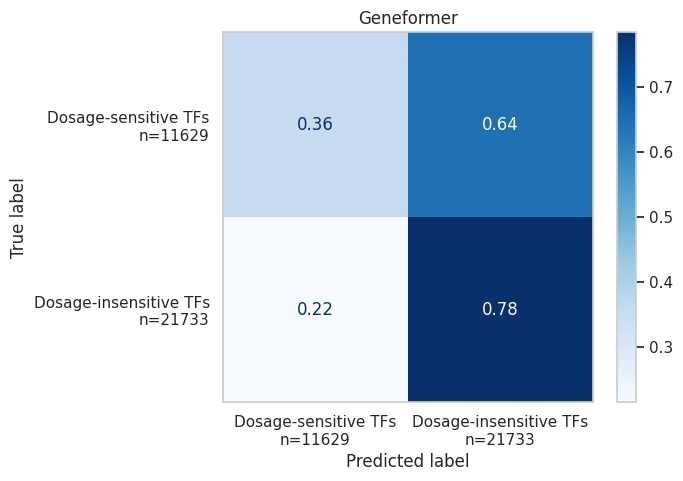

In [ ]:
cc.plot_conf_mat(
    conf_mat_dict={"Geneformer": all_metrics["conf_matrix"]},
    output_directory=output_dir,
    output_prefix=output_prefix,
)

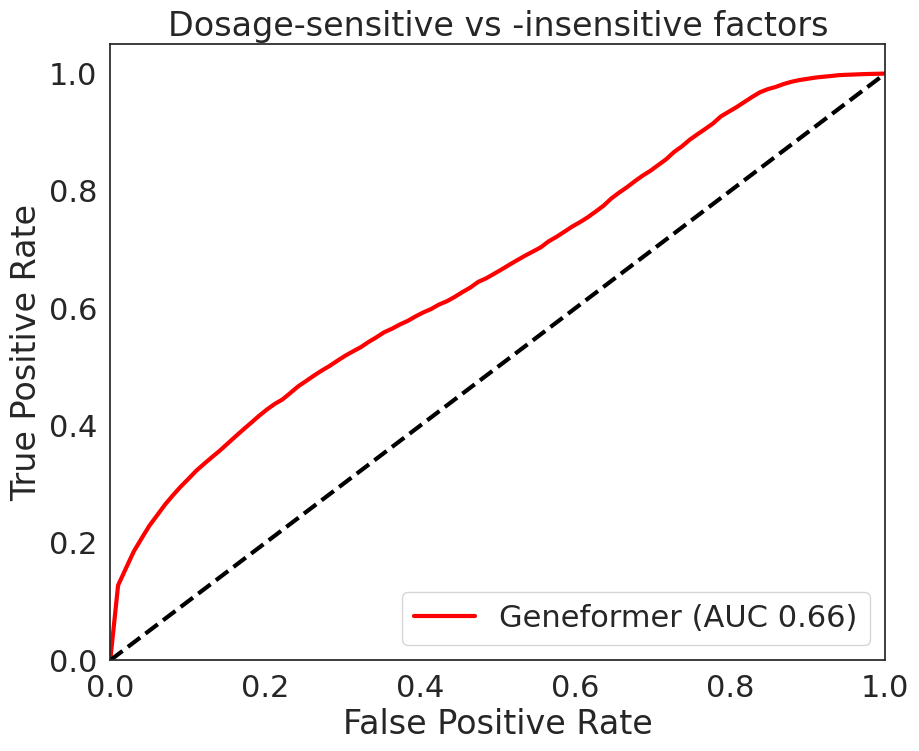

In [ ]:
cc.plot_roc(
    roc_metric_dict={"Geneformer": all_metrics["all_roc_metrics"]},
    model_style_dict={"Geneformer": {"color": "red", "linestyle": "-"}},
    title="Dosage-sensitive vs -insensitive factors",
    output_directory=output_dir,
    output_prefix=output_prefix,
)